#Volatility Forecasting

1. Dispersion of Financial Asset Returns Over Time

2. Std Dev or Variance of Price Returns

3. Higher the Volatility, riksier a financial asset becoems


In [ ]:
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm

!pip install arch
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings

In [ ]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')   x
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4

Hurst Exponent Function 

In [ ]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

Correlogram Plot

In [ ]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst:
     {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}
    \nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [ ]:
from google.colab import files
uploaded = files.upload()

import io
maticDF = pd.read_csv(io.BytesIO(uploaded['matic.csv']))

Saving matic.csv to matic (4).csv


In [ ]:
print(maticDF)
#maticDF = maticDF.set_index(['Date'])
print(type(maticDF))

                Price     Open     High      Low     Vol. Change %
Date                                                              
Oct 31, 2021  155.000  147.360  158.200  145.014  187.89K    5.18%
Oct 30, 2021  147.360  159.021  159.021  147.071  205.07K   -7.33%
Oct 29, 2021  159.021  166.969  174.427  142.000  424.20K   -4.76%
Oct 28, 2021  166.969  142.546  169.650  142.458  582.99K   17.13%
Oct 27, 2021  142.546  136.445  150.300  127.604  656.99K    4.47%
...               ...      ...      ...      ...      ...      ...
Aug 05, 2021   81.199   80.534   81.600   78.100  124.97K    0.83%
Aug 04, 2021   80.534   78.970   81.899   78.013  159.19K    1.98%
Aug 03, 2021   78.970   80.001   81.474   77.129  171.48K   -1.29%
Aug 02, 2021   80.001   81.117   82.872   78.610   81.05K   -1.38%
Aug 01, 2021   81.117   82.168   86.050   80.300   75.35K   -1.65%

[92 rows x 6 columns]
<class 'pandas.core.frame.DataFrame'>


In [ ]:
maticDF['Return'] = np.log(maticDF['Open']).diff().mul(100) 
maticDF = maticDF.dropna()
maticDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, Oct 30, 2021 to Aug 01, 2021
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     91 non-null     float64
 1   Open      91 non-null     float64
 2   High      91 non-null     float64
 3   Low       91 non-null     float64
 4   Vol.      91 non-null     object 
 5   Change %  91 non-null     object 
 6   Return    91 non-null     float64
dtypes: float64(5), object(2)
memory usage: 5.7+ KB


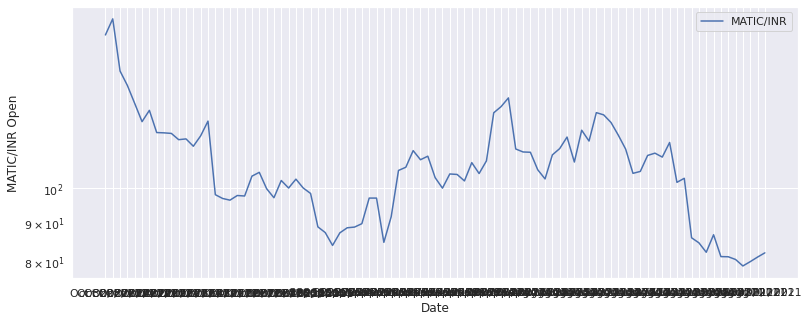

In [ ]:
fig, ax1 = plt.subplots(figsize=(13, 5))
ax1.set_yscale('log')
ax1.plot(maticDF.index, maticDF.Open, color='b', label='MATIC/INR')
ax1.set_xlabel('Date')
ax1.set_ylabel('MATIC/INR Open')
ax1.legend()
plt.show()

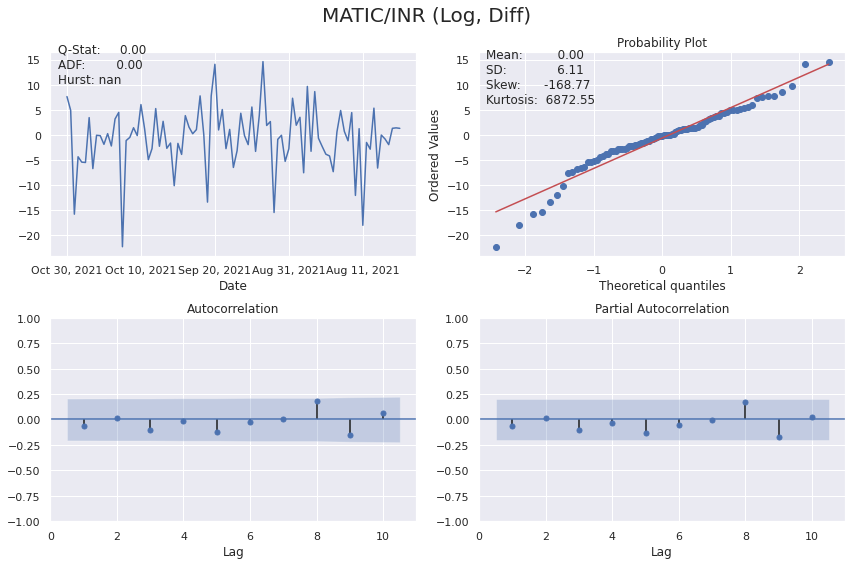

In [ ]:
plot_correlogram(maticDF['Return'], title='MATIC/INR (Log, Diff)')

In [ ]:
from google.colab import files
uploaded = files.upload()

import io
wrxDF = pd.read_csv(io.BytesIO(uploaded['wrx.csv']))

Saving wrx.csv to wrx.csv


            Date   Price    Open    High     Low    Vol. Change %
0   Oct 31, 2021  1.4300  1.3820  1.5430  1.3710  21.10M    3.77%
1   Oct 30, 2021  1.3780  1.3590  1.3800  1.3070   8.08M    1.62%
2   Oct 29, 2021  1.3560  1.3440  1.3830  1.3350   6.81M    0.97%
3   Oct 28, 2021  1.3430  1.3030  1.3840  1.2590  14.06M    2.52%
4   Oct 27, 2021  1.3100  1.4060  1.4680  1.2670  15.22M   -6.76%
..           ...     ...     ...     ...     ...     ...      ...
87  Aug 05, 2021  1.1085  1.0916  1.1129  1.0526   5.82M    1.70%
88  Aug 04, 2021  1.0900  1.0518  1.1054  1.0320   4.40M    4.03%
89  Aug 03, 2021  1.0478  1.0881  1.0926  1.0373   4.09M   -3.60%
90  Aug 02, 2021  1.0869  1.0883  1.1266  1.0696   5.77M    0.13%
91  Aug 01, 2021  1.0855  1.1283  1.1600  1.0760   7.47M   -3.52%

[92 rows x 7 columns]
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 1 to 91
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  -

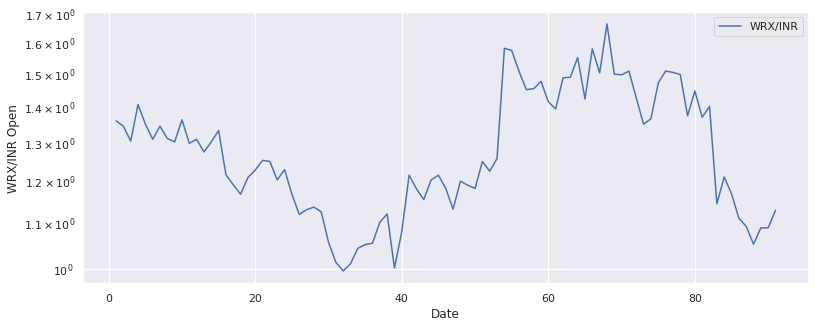

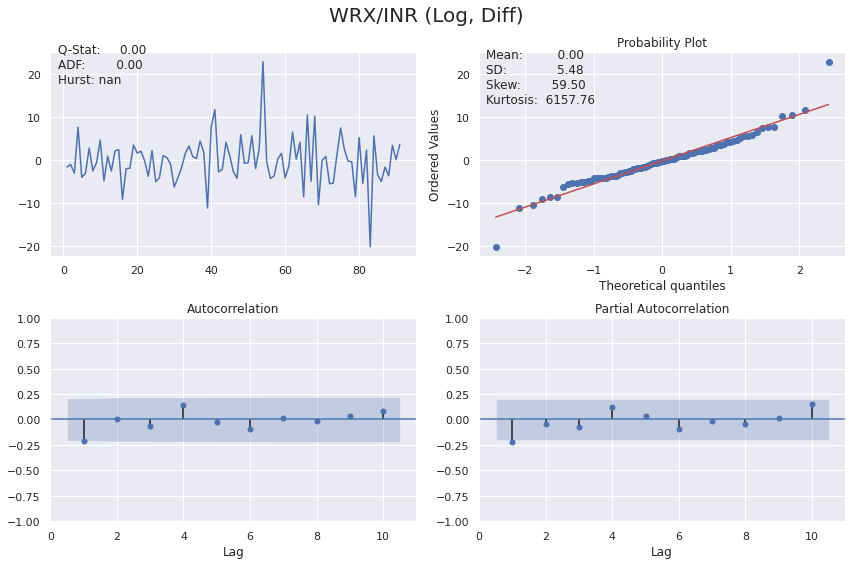

In [ ]:
print(wrxDF)
#maticDF = maticDF.set_index(['Date'])
print(type(wrxDF))

wrxDF['Return'] = np.log(wrxDF['Open']).diff().mul(100) 
wrxDF = wrxDF.dropna()
wrxDF.info()

fig, ax1 = plt.subplots(figsize=(13, 5))
ax1.set_yscale('log')
ax1.plot(wrxDF.index, wrxDF.Open, color='b', label='WRX/INR')
ax1.set_xlabel('Date')
ax1.set_ylabel('WRX/INR Open')
ax1.legend()
plt.show()

plot_correlogram(wrxDF['Return'], title='WRX/INR (Log, Diff)')

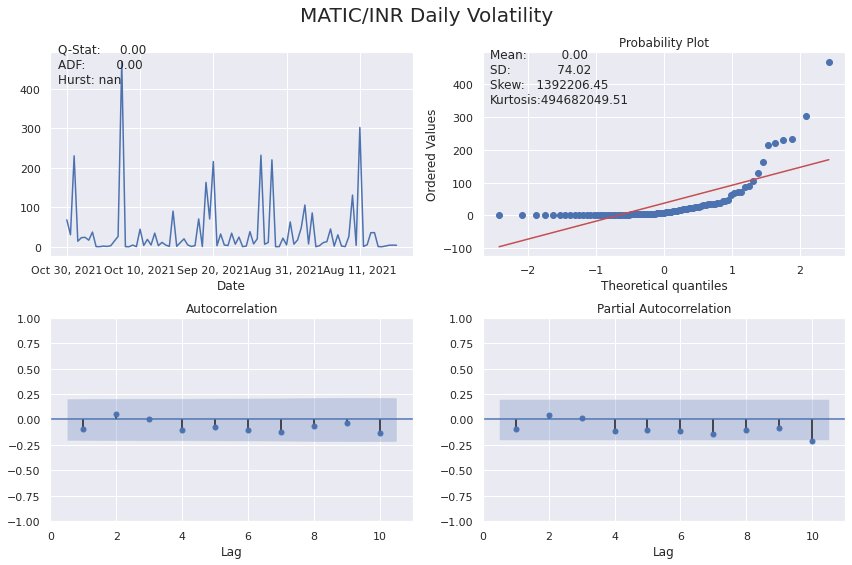

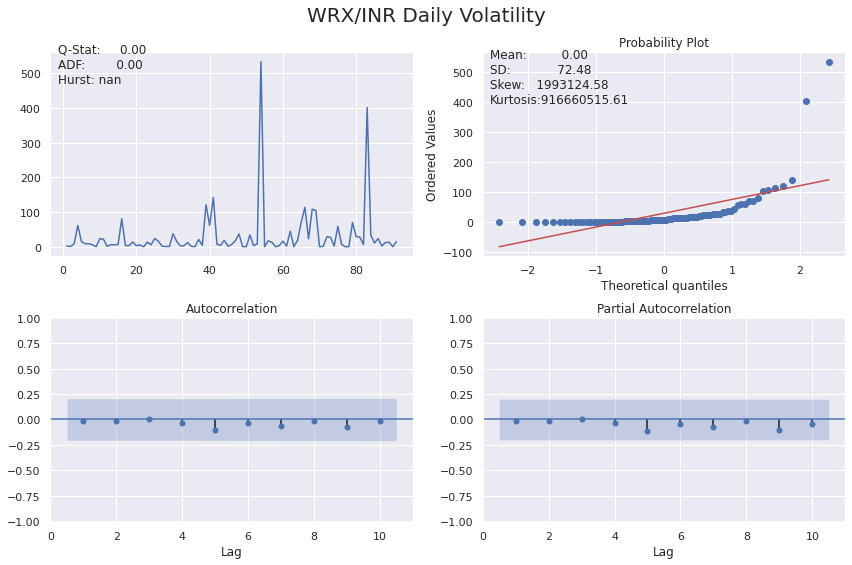

In [ ]:
plot_correlogram(maticDF['Return'].sub(maticDF['Return'].mean()).pow(2),
                 title='MATIC/INR Daily Volatility')
plot_correlogram(wrxDF['Return'].sub(wrxDF['Return'].mean()).pow(2),
                 title='WRX/INR Daily Volatility')

In [ ]:
# Specify GJR-GARCH model assumptions
gjr_gm = arch_model(maticDF['Return'], p = 1, q = 1, o = 1, vol = 'GARCH',
                    dist = 't')
# Fit the model
gjrgm_result = gjr_gm.fit(disp = 'off')
# Print model fitting summary
print(gjrgm_result.summary())

# Specify EGARCH model assumptions
egarch_gm = arch_model(maticDF['Return'], p = 1, q = 1, o = 1, vol = 'EGARCH',
                       dist = 't')
# Fit the model
egarch_result = egarch_gm.fit(disp = 'off')
# Print model fitting summary
print(egarch_result.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -287.688
Distribution:      Standardized Student's t   AIC:                           587.376
Method:                  Maximum Likelihood   BIC:                           602.442
                                              No. Observations:                   91
Date:                      Thu, Nov 25 2021   Df Residuals:                       90
Time:                              10:52:08   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0

In [ ]:
# Specify EGARCH model assumptions
egarch_gm = arch_model(maticDF['Return'], p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')

# Fit the model
egarch_result = egarch_gm.fit(disp = 'off')

# Print model fitting summary
print(egarch_result.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -279.741
Distribution:      Standardized Student's t   AIC:                           571.482
Method:                  Maximum Likelihood   BIC:                           586.548
                                              No. Observations:                   91
Date:                      Thu, Nov 25 2021   Df Residuals:                       90
Time:                              10:52:12   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

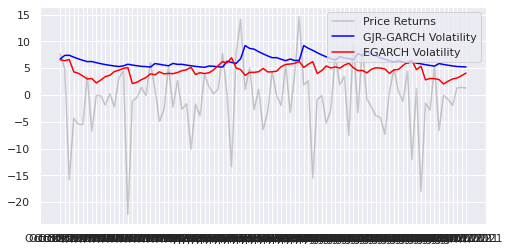

In [ ]:
gjrgm_vol = gjrgm_result.conditional_volatility
egarch_vol = egarch_result.conditional_volatility

# Plot the actual returns
plt.plot(maticDF['Return'], color = 'grey', alpha = 0.4, label = 'Price Returns')

# Plot GJR-GARCH estimated volatility
plt.plot(gjrgm_vol, color = 'blue', label = 'GJR-GARCH Volatility')

# Plot EGARCH  estimated volatility
plt.plot(egarch_vol, color = 'red', label = 'EGARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

In [ ]:
# Print each models BIC
print(f'GJR-GARCH BIC: {gjrgm_result.bic}')
print(f'\nEGARCH BIC: {egarch_result.bic}')

GJR-GARCH BIC: 602.4415734868724

EGARCH BIC: 586.5475069324489


Overall both GJR-GARCH and EGARCH models did a good job of fitting the actual data. Comparatively, GJR-GARCH is more conservative in volatility estimation when applying it to the MATIC/INR, but EGARCH yields the better model.



                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -275.154
Distribution:      Standardized Student's t   AIC:                           562.309
Method:                  Maximum Likelihood   BIC:                           577.374
                                              No. Observations:                   91
Date:                      Thu, Nov 25 2021   Df Residuals:                       90
Time:                              16:00:42   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0

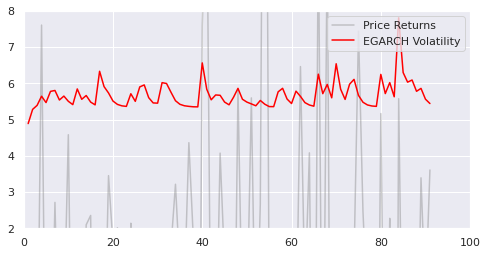

GJR-GARCH BIC: 577.3740917419472

EGARCH BIC: 580.443237545531


In [ ]:
# Specify GJR-GARCH model assumptions
gjr_gm = arch_model(wrxDF['Return'], p = 1, q = 1, o = 1, vol = 'GARCH', 
                    dist = 't')
# Fit the model
gjrgm_result = gjr_gm.fit(disp = 'off')
print(gjrgm_result.summary())
egarch_gm = arch_model(wrxDF['Return'], p = 1, q = 1, o = 1, vol = 'EGARCH',
                       dist = 't')
egarch_result = egarch_gm.fit(disp = 'off')
print(egarch_result.summary())
gjrgm_vol = gjrgm_result.conditional_volatility
egarch_vol = egarch_result.conditional_volatility
# Plot the actual returns
plt.axis([0, 100, 2, 8])
plt.plot(wrxDF['Return'], color = 'grey', alpha = 0.4, label = 'Price Returns')
plt.plot(egarch_vol, color = 'red', label = 'EGARCH Volatility')
plt.legend(loc = 'upper right')
plt.show()
# Print each models BIC
print(f'GJR-GARCH BIC: {gjrgm_result.bic}')
print(f'\nEGARCH BIC: {egarch_result.bic}')

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
def evaluate(observation, forecast): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print(f'Mean Absolute Error (MAE): {round(mae,3)}')
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print(f'Mean Squared Error (MSE): {round(mse,3)}')
    return mae, mse

# Backtest model with MAE, MSE
evaluate(maticDF['Return'].sub(maticDF['Return'].mean()).pow(2), egarch_vol**2)

Mean Absolute Error (MAE): 41.381
Mean Squared Error (MSE): 5576.677


(41.380759771580514, 5576.67716087977)

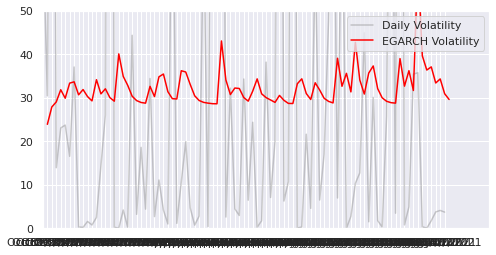

In [ ]:
# Plot the actual volatility
plt.axis([0,100,0,50])
plt.plot(maticDF['Return'].sub(maticDF['Return'].mean()).pow(2), 
         color = 'grey', alpha = 0.4, label = 'Daily Volatility')

# Plot EGARCH  estimated volatility
plt.plot(egarch_vol**2, color = 'red', label = 'EGARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

In [ ]:
def evaluate(observation, forecast): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print(f'Mean Absolute Error (MAE): {round(mae,3)}')
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print(f'Mean Squared Error (MSE): {round(mse,3)}')
    return mae, mse

# Backtest model with MAE, MSE
evaluate(wrxDF['Return'].sub(wrxDF['Return'].mean()).pow(2), egarch_vol**2)

Mean Absolute Error (MAE): 35.898
Mean Squared Error (MSE): 5288.49


(35.898373823140496, 5288.490142964919)

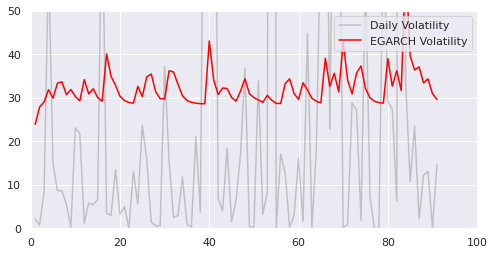

In [ ]:
# Plot the actual volatility
plt.axis([0, 100, 0, 50])
plt.plot(wrxDF['Return'].sub(wrxDF['Return'].mean()).pow(2), 
         color = 'grey', alpha = 0.4, label = 'Daily Volatility')

# Plot EGARCH  estimated volatility
plt.plot(egarch_vol**2, color = 'red', label = 'EGARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

In [ ]:
print(maticDF.describe())

          Return         Low        High        Open       Price
count  91.000000   91.000000   91.000000   91.000000   91.000000
mean   -0.641882   99.252363  111.517615  106.164769  106.881165
std     6.143578   15.811043   18.039246   16.570331   16.926747
min   -22.297415   65.000000   81.474000   78.970000   78.970000
25%    -3.024194   86.250500   99.667000   96.999500   97.050000
50%    -0.146725   98.412000  110.784000  104.871000  105.159000
75%     2.921881  110.100000  119.899500  115.542000  115.917000
max    14.582280  147.071000  174.427000  166.969000  166.969000


In [ ]:
print(wrxDF.describe())

           Price       Open       High        Low     Return
count  91.000000  91.000000  91.000000  91.000000  91.000000
mean    1.282068   1.279454   1.339871   1.227203  -0.222879
std     0.163305   0.163272   0.171948   0.154054   5.513484
min     0.999000   0.995000   1.030000   0.962000 -20.245724
25%     1.160000   1.148950   1.210500   1.108000  -3.607066
50%     1.252000   1.252000   1.347000   1.200000  -0.279051
75%     1.410500   1.410000   1.491500   1.358850   2.409976
max     1.665400   1.662400   1.745400   1.490000  22.869692


In [ ]:
print(maticDF.skew(axis=1))
print(wrxDF.skew(axis=1))

Date
Oct 30, 2021   -2.190561
Oct 29, 2021   -2.079585
Oct 28, 2021   -2.082283
Oct 27, 2021   -2.144759
Oct 26, 2021   -2.185392
                  ...   
Aug 05, 2021   -2.228337
Aug 04, 2021   -2.226870
Aug 03, 2021   -2.224661
Aug 02, 2021   -2.225244
Aug 01, 2021   -2.215218
Length: 91, dtype: float64
1    -2.233452
2    -2.234562
3    -2.232990
4     2.231616
5    -2.234215
        ...   
87   -2.234036
88   -2.235022
89    2.233035
90   -2.225493
91    2.230969
Length: 91, dtype: float64


In [ ]:
print(maticDF.kurt(axis=1))
print(wrxDF.kurt(axis=1))

Date
Oct 30, 2021    4.837512
Oct 29, 2021    4.410938
Oct 28, 2021    4.454801
Oct 27, 2021    4.673036
Oct 26, 2021    4.824528
                  ...   
Aug 05, 2021    4.971661
Aug 04, 2021    4.967259
Aug 03, 2021    4.959013
Aug 02, 2021    4.961501
Aug 01, 2021    4.928393
Length: 91, dtype: float64
1     4.990503
2     4.994655
3     4.988984
4     4.984039
5     4.993401
        ...   
87    4.992648
88    4.996255
89    4.989162
90    4.963059
91    4.981648
Length: 91, dtype: float64
